In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pandas as pd
from sklearn.linear_model import LinearRegression 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import r2_score 
from sklearn.preprocessing import StandardScaler
from pyspark.sql.functions import avg, stddev
from sklearn import preprocessing

gpa_gre_path = 'D:\Courses\Big Data Tools and Methods CS-696\Assignments\Codes\Assignments 3\gpa-gre.csv'

multiple_sites_path = 'D:\Courses\Big Data Tools and Methods CS-696\Assignments\Codes\Assignments 3\dwelldata\multiple-sites.tsv'

In [2]:
def regression_function(model): 
    return lambda x: x * model.coef_[0] + model.intercept_ 

Problem 1. The dataset GPA-GRE contains  16 years of GPA, Verbal and Quantitative GRE scores for graduate students. 

a. Use linear regression with the combined GRE score (Verbal + Quantitive) as the indepen-
dent variable and the GPA as the dependent variable to create a model that predicts a stu-
dents GPA given their combined GRE score. 

b. What is the r2 score of the model?

c. Plot the residuals of the data from the model.

Co ef    :0.0006342248187308269
intercept:2.754643759391385


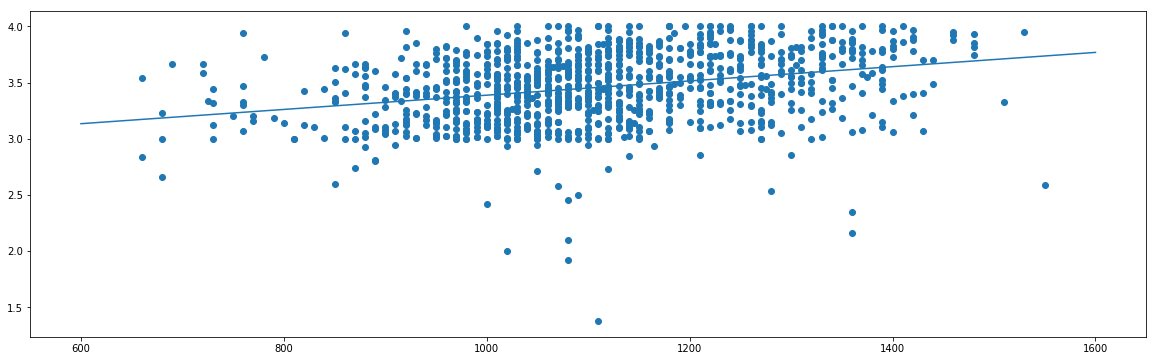

In [9]:
# Problem 1.a
score_df = pd.read_csv(gpa_gre_path).dropna()
score_df = score_df.assign(v_q_combine=score_df['Verbal'] + score_df['Quant'])
x = score_df['v_q_combine']
x = x[:,np.newaxis] 
y = score_df['GPA']

model = LinearRegression(fit_intercept=True) 
model.fit( x,y )

print('Co ef    :', end = '')
print(model.coef_[0])

print('intercept:', end = '')
print(model.intercept_)

regression = regression_function(model) 
regression(1)
plt.figure(figsize=(20,6)) 
plt.scatter(x, y); 
xfit = np.linspace(600,1600, num=y.size) 
plt.plot(xfit, regression(xfit))

In [4]:
## b. What is the r2 score of the model?
r2 = r2_score(y, model.predict(x))
print('r2_score:')
print(r2)

r2_score:
0.08605591062231854


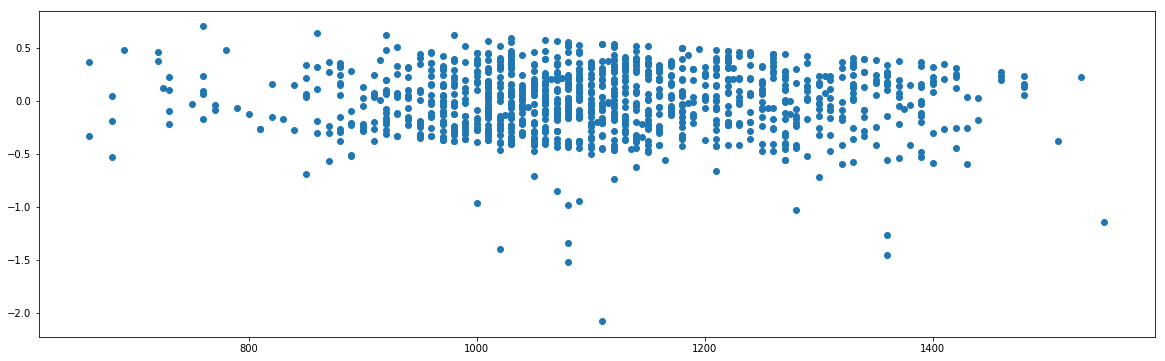

In [5]:
## c. Plot the residuals of the data from the model.
residual = y - model.predict(x)
plt.figure(figsize=(20,6)) 
plt.scatter(x, residual); 

Problem 2.  In the dataset dwell data there is a ﬁle multiple-site.tsv. The ﬁle contains two columns: a site number and dwell-time on that site.  Each site contains multiple entires.

Using scikitlearn compute the mean and standard deviation of the dwell time per site.

Using Spark (not scikitlearn) compute the mean and standard deviation of the dwell time per site.

In [6]:
## Using sci kit learn

dwell_df = pd.read_csv(multiple_sites_path, sep='\t')
sites = dwell_df['site'].unique()
means = pd.DataFrame(columns= ['site', 'mean', 'std'])
means_without = pd.DataFrame(columns= ['site', 'mean', 'std'])

for a_site in sites:
    site_dwell = dwell_df.loc[dwell_df['site'] == a_site]
    dwell_time = (site_dwell['dwell-time'].astype('float64'))[:,np.newaxis] 
    scaler = StandardScaler()
    scaler.fit(dwell_time)
    means = means.append({'site':a_site, 'mean':scaler.mean_[0], 'std': scaler.scale_[0]}, ignore_index=True)

means.site = means.site.astype(int)
means = means.sort_values(by=['site']).reset_index()
means.drop(["index"], axis = 1, inplace = True) 
means

,site,mean,std
0,0,79.851064,78.288876
1,1,106.000000,102.547086
2,2,88.229167,87.780085
3,3,97.479167,74.030678
4,4,94.333333,76.960052
5,5,102.333333,86.650273
6,6,144.192982,145.636346
7,7,123.367347,115.825290
8,8,94.346939,96.563937
9,9,89.820000,99.460684


In [8]:
# ##Using Spark
reader = spark.read 
reader.option("header",True) 
reader.option("inferSchema",True) 
reader.option("sep", "\t") 
dwell_df = reader.csv(multiple_sites_path) 
result = dwell_df.groupBy('site')\
    .agg(avg('dwell-time')\
    ,stddev('dwell-time') )\
    .orderBy('site')
result.show()

+----+------------------+-----------------------+
|site|   avg(dwell-time)|stddev_samp(dwell-time)|
+----+------------------+-----------------------+
|   0| 79.85106382978724|      79.13526634363751|
|   1|             106.0|     103.79012594607659|
|   2| 88.22916666666667|      88.70900061876551|
|   3| 97.47916666666667|       74.8140928763278|
|   4| 94.33333333333333|      77.72584297816697|
|   5|102.33333333333333|       87.7006178654617|
|   6|144.19298245614036|     146.93091654103628|
|   7|123.36734693877551|     117.02558371953526|
|   8| 94.34693877551021|      97.56462623572646|
|   9|             89.82|     100.47046271193848|
|  10|129.95238095238096|      90.10940569215181|
|  11| 96.98214285714286|      78.94635487501591|
|  12| 80.95081967213115|      68.98729985282513|
|  13| 90.73770491803279|     102.01387187360751|
|  14| 74.76470588235294|      78.26278508596386|
|  15|119.34782608695652|     107.02050009046641|
|  16| 86.74418604651163|     118.83523868570455|
